In [2]:
#import libraries
import os as os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import networkx as nx
import shapely as shply
import folium as fm
import elevation as elev
from networkx import shortest_path
import mapclassify


In [3]:
#evacuation zone shape files
xl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XL_Tsunami_Inundation_Scenario.shp')
xxl_ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Statewide_Tsunami_Scenarios/Statewide_XXL_Tsunami_Inundation_Scenario.shp')

#critical facilities shape file
critical_facil = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/CriticalFacilities.shp')
#reprojecting
critical_facil = critical_facil.to_crs('EPSG:32610')


In [4]:
#reprojecting ev zones
xxl_ev_zones = xxl_ev_zones.to_crs('EPSG:32610')
xl_ev_zones = xl_ev_zones.to_crs('EPSG:32610')

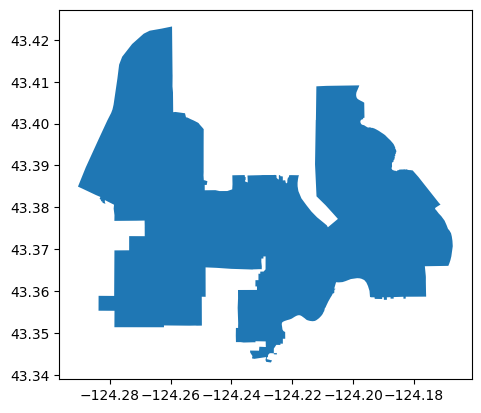

In [5]:
ox.settings.log_console=True
# define the place query for coos bay on osmnx
query = {'city': 'Coos Bay'}

# get the boundaries of the city limits
gdf_coos = ox.geocode_to_gdf(query)
gdf_coos.plot()

coos_bay = gdf_coos.envelope
coos_bay = coos_bay.scale(2,4,2)

In [6]:
coos_bay
coos_bay = coos_bay.to_crs('EPSG:32610')

In [7]:
#checking coos bay data
gdf_coos.head()

geometry  bbox_north  bbox_south  \
0  POLYGON ((-124.29044 43.38495, -124.28897 43.3...    43.42319   43.342956   

    bbox_east   bbox_west   place_id  osm_type  osm_id        lat         lon  \
0 -124.167292 -124.290437  298362632  relation  186285  43.367894 -124.217465   

                                        display_name     class  \
0  Coos Bay, Coos County, Oregon, 97420, United S...  boundary   

             type  importance  
0  administrative    0.656381

In [8]:
#getting coos bay building data
tags = {'building': True}
cb_buildings = ox.geometries_from_place('Coos Bay, Oregon, USA', tags)


/Users/maxspiegel/.gds/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

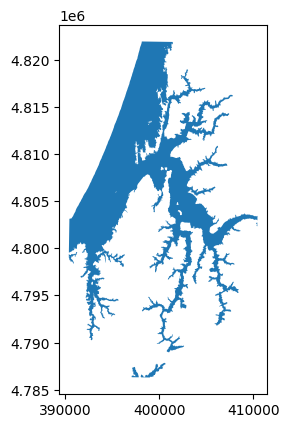

In [9]:
#clipping evacuation zones to coos bay area)
#xxl
clipped_ev_xxl = xxl_ev_zones.clip(coos_bay)

#xl
clipped_ev_xl = xl_ev_zones.clip(coos_bay)

clipped_ev_xl.plot()

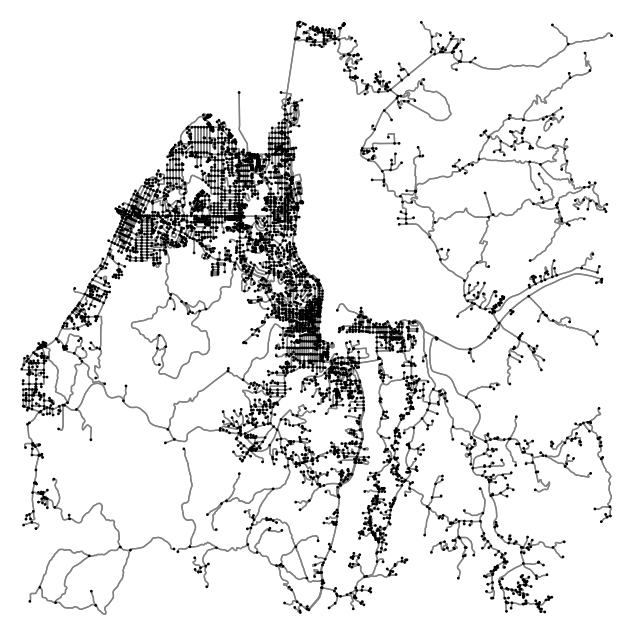

In [10]:
#creating coos bay network
lat_lon = (43.3672, -124.2131)
coos_ntwrk = ox.graph_from_point(lat_lon, dist=8000, network_type='walk')
fig, ax = ox.plot_graph(coos_ntwrk, bgcolor='white', node_color='black', edge_color='grey', node_size=4)

node_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=True, edges=False)
node_graph = node_graph.to_crs('EPSG:32610')
edge_graph = ox.graph_to_gdfs(coos_ntwrk, nodes=False, edges=True)
edge_graph = edge_graph.to_crs('EPSG:32610')
node_clip = node_graph.clip(coos_bay)


<AxesSubplot: >

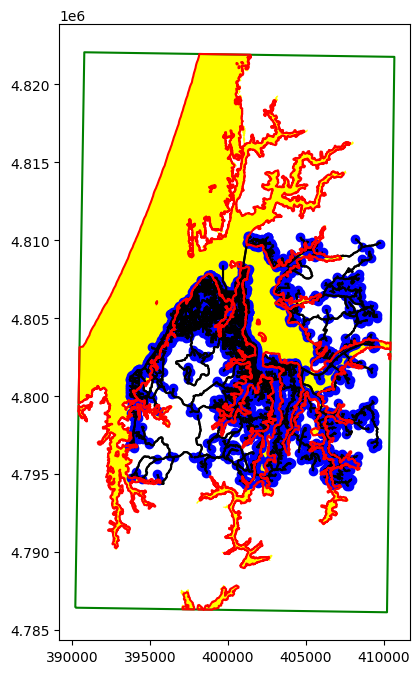

In [11]:
#graphing the network with the evacuation zones, and coos bay city limits
fig, ax = plt.subplots(figsize=(8, 8))
clipped_ev_xxl.plot(ax=ax, color= "yellow")
node_graph.plot(ax=ax, color= "blue")
edge_graph.plot(ax=ax, color="black")
coos_bay.boundary.plot(ax=ax, color="green")
clipped_ev_xl.boundary.plot(ax=ax, color = 'red')

In [12]:
#assembly areas and higher ground shape files + reproject
assembly_areas =gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/Assembly_Areas.shp')
assembly_areas= assembly_areas.to_crs('EPSG:32610')
#clipping assembly areas
clipped_assembly_areas = assembly_areas.clip(coos_bay)

higher_ground = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/GitHub/Tsunami-Scenarios/OutsideHazardArea_GreenHighGround.shp')
higher_ground= higher_ground.to_crs('EPSG:32610')
higher_ground_clip = higher_ground.clip(coos_bay)

/Users/maxspiegel/.gds/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [13]:
#clipping critical facil to coos bay area
crit_clip = critical_facil.clip(coos_bay)
crit_clip

Id Site_Type                                          Name     POINT_X  \
572   0    BRIDGE                       Beaver Creek, Hwy 35 EB -124.235726   
573   0    BRIDGE                       Beaver Creek, Hwy 35 WB -124.235962   
606   0    BRIDGE                    South Slough, County Rd 68 -124.319677   
570   0    BRIDGE                       Davis Slough, Hwy 35 EB -124.226242   
571   0    BRIDGE                               Hwy 35 over COR -124.225056   
..   ..       ...                                           ...         ...   
638   0    BRIDGE                    WILLANCH CREEK WEST BRIDGE -124.155940   
641   0    BRIDGE  WILLANCH CREEK BRIDGE @ MP 3.50 WILLANCH WAY -124.132003   
592   0    BRIDGE        Blackmoor/Larson Creek, County Rd 248G -124.139034   
654   0    BRIDGE               Shutter Creek, Larsen Ranch Rd. -124.154958   
593   0    BRIDGE                  Shutters Creek, County Rd 25 -124.157108   

       POINT_Y                        geometry  
572  43.227371  POINT (399648.580 4786806.230)  
573  43.227415  POINT (399629.487 4786811.400)  
606  43.276195  POINT (392916.637 4792332.620)  
570  43.288484  POINT (400518.331 4793581.845)  
571  43.245731  POINT (400544.944 4788832.536)  
..         ...                             ...  
638  43.410880  POINT (406409.980 4807093.370)  
641  43.417508  POINT (408357.996 4807802.849)  
592  43.480757  POINT (407884.868 4814834.981)  
654  43.538323  POINT (406685.759 4821245.937)  
593  43.542398  POINT (406518.351 4821700.920)  

[110 rows x 6 columns]

<AxesSubplot: >

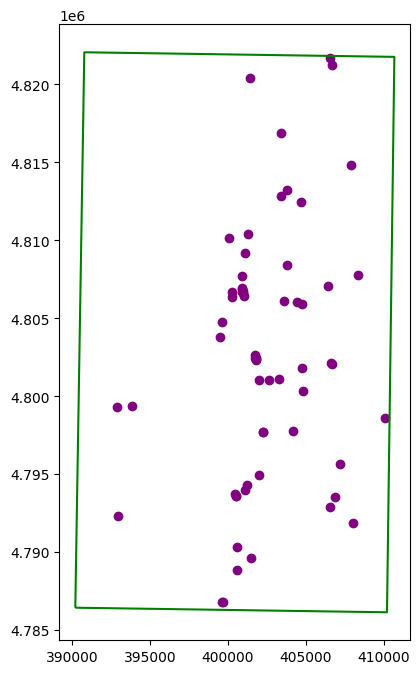

In [14]:
#filtering out for just the bridges, plotting 
bridge_crit = crit_clip[crit_clip['Site_Type'] == 'BRIDGE']

fig, ax = plt.subplots(figsize=(12, 8))
coos_bay.boundary.plot(ax=ax, color="green")
bridge_crit.plot(ax=ax, color= 'purple')

In [15]:
#making the nodes an array
array_nodes = node_graph.index.values

In [16]:
x_1_assembly = clipped_assembly_areas['geometry'].x
y_1_assembly = clipped_assembly_areas['geometry'].y

In [17]:
# Convert to graph
g_proj = ox.project_graph(coos_ntwrk, to_crs=None)
g_proj

In [18]:
#clipping node layer
node_clip = node_clip.clip(clipped_ev_xxl)

#variables
#clipped_assembly_areas
#edge_graph

In [19]:
node_id = node_clip
node_id["id"] = node_id.index
node_id

y           x  street_count highway  \
osmid                                                     
38111515    43.295556 -124.149964             3     NaN   
38211421    43.297819 -124.150137             3     NaN   
6281238892  43.298783 -124.154491             3     NaN   
6281238920  43.301206 -124.154641             3     NaN   
38295377    43.301283 -124.151724             3     NaN   
...               ...         ...           ...     ...   
8111674628  43.409639 -124.240394             3     NaN   
8111674627  43.409647 -124.240927             3     NaN   
8111674633  43.410071 -124.240838             3     NaN   
8111674630  43.410176 -124.240658             3     NaN   
38278587    43.421634 -124.239337             1     NaN   

                                  geometry          id  
osmid                                                   
38111515    POINT (406718.433 4794278.588)    38111515  
38211421    POINT (406707.860 4794530.166)    38211421  
6281238892  POINT (406356.224 4794642.084)  6281238892  
6281238920  POINT (406347.703 4794911.362)  6281238920  
38295377    POINT (406584.476 4794916.624)    38295377  
...                                    ...         ...  
8111674628  POINT (399571.309 4807053.241)  8111674628  
8111674627  POINT (399528.151 4807054.749)  8111674627  
8111674633  POINT (399536.058 4807101.731)  8111674633  
8111674630  POINT (399550.830 4807113.208)  8111674630  
38278587    POINT (399676.721 4808384.107)    38278587  

[1563 rows x 6 columns]

In [20]:
test_node = node_id[node_id["id"]==8111674633]
test_node

y           x  street_count highway  \
osmid                                                     
8111674633  43.410071 -124.240838             3     NaN   

                                  geometry          id  
osmid                                                   
8111674633  POINT (399536.058 4807101.731)  8111674633

In [21]:
target_node = clipped_assembly_areas[clipped_assembly_areas["Location"]=="Mormon Church"]
target_node

Location notes County            Evac_Map  \
113  Mormon Church  None   Coos  Coos Bay Peninsula   

                           geometry  
113  POINT (398433.373 4806739.672)

In [22]:
#orig_xy = [test_node['geometry'].y.values[0], test_node['geometry'].x.values[0]]
#target_xy = [target_node['geometry'].y.values[0], target_node['geometry'].x.values[0]]

In [23]:
#orig_n = ox.distance.nearest_nodes(g_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)
#target_n = ox.distance.nearest_nodes(g_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [24]:
target_xy = [clipped_assembly_areas['geometry'].y.values, clipped_assembly_areas['geometry'].x.values]
target_nodes = ox.distance.nearest_nodes(g_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [25]:
origin_xy =[node_clip['geometry'].y.values, node_clip['geometry'].x.values]
origin_nodes= ox.distance.nearest_nodes(g_proj, X=origin_xy[1], Y=origin_xy[0], return_dist=False)


In [26]:
target_nodes

[38243704,
 2699166298,
 38229552,
 38093284,
 38173544,
 38243502,
 10254592186,
 6363768709,
 6247432540,
 2690042393,
 9711163766,
 6247530350,
 38243871,
 10257701806,
 10257701767,
 38219946,
 38224742]

In [27]:
orig_node = node_id[node_id["id"]==8111674633]
orig_xy = [orig_node['geometry'].y.values[0], orig_node['geometry'].x.values[0]]
orig_n = ox.distance.nearest_nodes(g_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

In [28]:
len(target_nodes)

17

In [29]:
routes = []
lengths = []
for i in range(len(target_nodes)):
    routes.append(nx.shortest_path(g_proj, source=orig_n, target=target_nodes[i], weight='length'))
    lengths.append(nx.shortest_path_length(g_proj, source=orig_n, target=target_nodes[i], weight='length'))

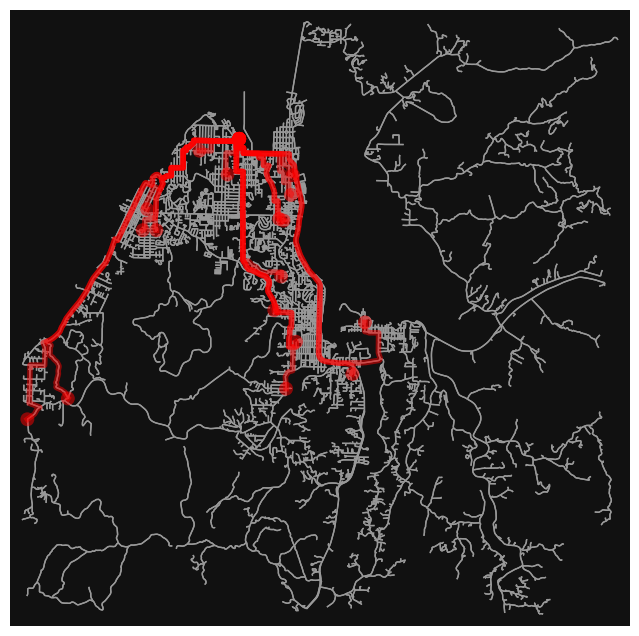

In [30]:
fig, ax = ox.plot_graph_routes(g_proj, routes,route_linewidth=6, node_size=0)

In [31]:
routes = []
lengths = []
for i in range(len(target_nodes)):
    routes.append(nx.shortest_path(g_proj, source=origin_nodes[i], target=target_nodes[i], weight='length'))
    lengths.append(nx.shortest_path_length(g_proj, source=origin_nodes[i], target=target_nodes[i], weight='length'))

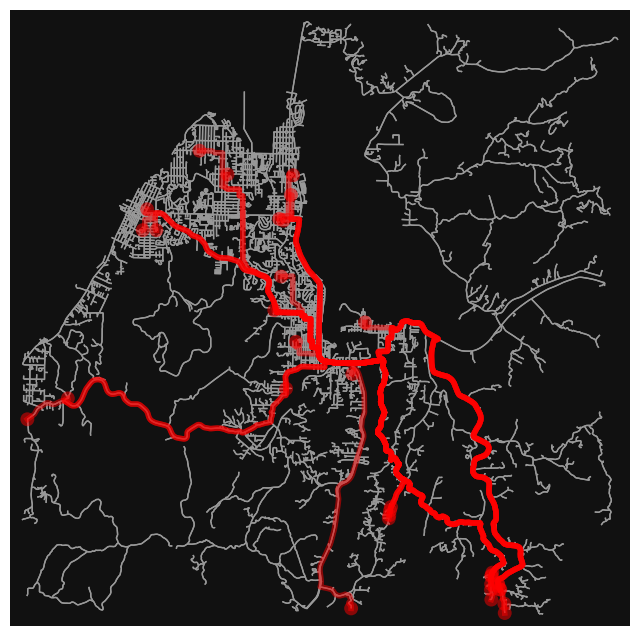

In [32]:
fig, ax = ox.plot_graph_routes(g_proj, routes,route_linewidth=6, node_size=0)

In [33]:
routes = []
lengths = []
routes_final = []
lengths_final= []
nodes_final = []
node_index = -1
for origin in range(len(origin_nodes)):
    node_index += 1
    og_node = origin_nodes[node_index]
    nodes_final.append(og_node)
    for i in range(len(target_nodes)):
        routes.append(nx.shortest_path(g_proj, source=og_node, target=target_nodes[i], weight='length'))
        lengths.append(nx.shortest_path_length(g_proj, source=og_node, target=target_nodes[i], weight='length'))
    min_len = min(lengths)
    min_index = lengths.index(min_len)
    min_route = routes[min_index]
    lengths_final.append(min_len)
    routes_final.append(min_route)
    routes = []
    lengths = []

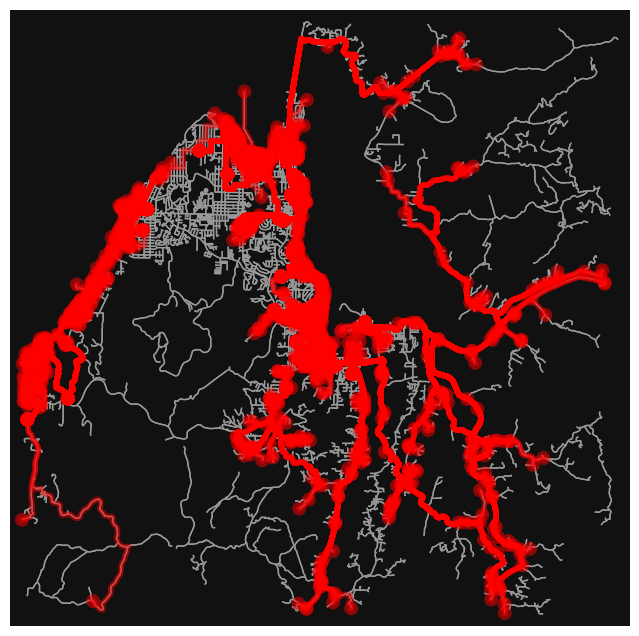

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [34]:
ox.plot_graph_routes(g_proj, routes_final,route_linewidth=6, node_size=0)

In [35]:
def len_function(e):
    return len(e)


routes_final.sort(key=len_function)
sorted_routes = routes_final
sorted_routes

[[38304019, 38229552],
 [38229553, 38229552],
 [2699101144, 2699166298],
 [38212705, 38229553, 38229552],
 [38289599, 38275448, 38243704],
 [6373280924, 2699101144, 2699166298],
 [38311954, 2699101144, 2699166298],
 [10257701693, 38217222, 38243871],
 [38012189, 38229546, 38169954, 38229552],
 [38299073, 38229546, 38169954, 38229552],
 [38229566, 38212705, 38229553, 38229552],
 [38250381, 38289599, 38275448, 38243704],
 [38289606, 38289599, 38275448, 38243704],
 [38237172, 6373280924, 2699101144, 2699166298],
 [6373280982, 38311954, 2699101144, 2699166298],
 [6373280990, 38311954, 2699101144, 2699166298],
 [38207365, 5180561880, 38207348, 38093284],
 [38243868, 10257701693, 38217222, 38243871],
 [38012207, 38012189, 38229546, 38169954, 38229552],
 [38229538, 38012189, 38229546, 38169954, 38229552],
 [6579902767, 38229566, 38212705, 38229553, 38229552],
 [10254592131, 38244068, 38250027, 38173543, 38173544],
 [6243231581, 38229566, 38212705, 38229553, 38229552],
 [38275434, 38289606, 38

In [36]:
import pandas as pd
nodes_df = pd.DataFrame(lengths_final, index=nodes_final,  columns =['Distance_m'])
nodes_df["id"] = nodes_df.index
nodes_df

Distance_m          id
38111515     12290.834    38111515
38211421     12037.976    38211421
6281238892   10392.611  6281238892
6281238920   10107.046  6281238920
38295377     11621.578    38295377
...                ...         ...
8111674628    1349.851  8111674628
8111674627    1306.771  8111674627
8111674633    1354.787  8111674633
8111674630    1373.474  8111674630
38278587      3056.054    38278587

[1563 rows x 2 columns]

In [37]:
node_id = node_id.merge(nodes_df, on='id')
node_id

y           x  street_count highway  \
0     43.295556 -124.149964             3     NaN   
1     43.297819 -124.150137             3     NaN   
2     43.298783 -124.154491             3     NaN   
3     43.301206 -124.154641             3     NaN   
4     43.301283 -124.151724             3     NaN   
...         ...         ...           ...     ...   
1558  43.409639 -124.240394             3     NaN   
1559  43.409647 -124.240927             3     NaN   
1560  43.410071 -124.240838             3     NaN   
1561  43.410176 -124.240658             3     NaN   
1562  43.421634 -124.239337             1     NaN   

                            geometry          id  Distance_m  
0     POINT (406718.433 4794278.588)    38111515   12290.834  
1     POINT (406707.860 4794530.166)    38211421   12037.976  
2     POINT (406356.224 4794642.084)  6281238892   10392.611  
3     POINT (406347.703 4794911.362)  6281238920   10107.046  
4     POINT (406584.476 4794916.624)    38295377   11621.578  
...                              ...         ...         ...  
1558  POINT (399571.309 4807053.241)  8111674628    1349.851  
1559  POINT (399528.151 4807054.749)  8111674627    1306.771  
1560  POINT (399536.058 4807101.731)  8111674633    1354.787  
1561  POINT (399550.830 4807113.208)  8111674630    1373.474  
1562  POINT (399676.721 4808384.107)    38278587    3056.054  

[1563 rows x 7 columns]

In [38]:
node_id['speed_15m_kmh'] = (node_id['Distance_m']/1000)/(0.25)
node_id.head()

y           x  street_count highway  \
0  43.295556 -124.149964             3     NaN   
1  43.297819 -124.150137             3     NaN   
2  43.298783 -124.154491             3     NaN   
3  43.301206 -124.154641             3     NaN   
4  43.301283 -124.151724             3     NaN   

                         geometry          id  Distance_m  speed_15m_kmh  
0  POINT (406718.433 4794278.588)    38111515   12290.834      49.163336  
1  POINT (406707.860 4794530.166)    38211421   12037.976      48.151904  
2  POINT (406356.224 4794642.084)  6281238892   10392.611      41.570444  
3  POINT (406347.703 4794911.362)  6281238920   10107.046      40.428184  
4  POINT (406584.476 4794916.624)    38295377   11621.578      46.486312

In [39]:
node_id['time_walk_min'] = node_id['Distance_m']/72
node_id.head()

y           x  street_count highway  \
0  43.295556 -124.149964             3     NaN   
1  43.297819 -124.150137             3     NaN   
2  43.298783 -124.154491             3     NaN   
3  43.301206 -124.154641             3     NaN   
4  43.301283 -124.151724             3     NaN   

                         geometry          id  Distance_m  speed_15m_kmh  \
0  POINT (406718.433 4794278.588)    38111515   12290.834      49.163336   
1  POINT (406707.860 4794530.166)    38211421   12037.976      48.151904   
2  POINT (406356.224 4794642.084)  6281238892   10392.611      41.570444   
3  POINT (406347.703 4794911.362)  6281238920   10107.046      40.428184   
4  POINT (406584.476 4794916.624)    38295377   11621.578      46.486312   

   time_walk_min  
0     170.706028  
1     167.194111  
2     144.341819  
3     140.375639  
4     161.410806

In [42]:
#import mapclassify as m

xxl_bound = clipped_ev_xxl.boundary
m = node_id.explore(
     column="Distance_m", 
     scheme="naturalbreaks",       
     tooltip="speed_15m_kmh",
     popup=True,                     
     tiles="CartoDB positron",       
     cmap="YlOrRd",                  
     name="Nodes"
    )
xxl_bound.explore(
     m=m,
     color="red", 
     name="Evac zone" 
)
clipped_assembly_areas.explore(
     m=m, 
     color="darkmagenta", 
     marker_kwds=dict(radius=5, fill=True), 
     tooltip="Location", 
     tooltip_kwds=dict(labels=False),
     name="Assembly Areas" 


)
fm.TileLayer('cartodbdark_matter').add_to(m)
fm.LayerControl().add_to(m)
m


In [43]:
m.save('map.coosbay.html')

In [46]:
w = node_id.explore(
     column="speed_15m_kmh", 
     scheme="naturalbreaks",       
     tooltip="Distance_m",
     popup=True,                     
     tiles="CartoDB positron",       
     cmap="YlOrRd",                  
     name="Nodes"
    )
xxl_bound.explore(
     m=m,
     color="red", 
     name="Evac zone" 
)
clipped_assembly_areas.explore(
     m=m, 
     color="darkmagenta", 
     marker_kwds=dict(radius=5, fill=True), 
     tooltip="Location", 
     tooltip_kwds=dict(labels=False),
     name="Assembly Areas" 


)
fm.TileLayer('cartodbdark_matter').add_to(w)
fm.LayerControl().add_to(w)
w